# E‑commerce RFM & CLV Analysis 📊

**Objective**  
Identify high‑value customer segments and quantify revenue potential using RFM scoring and 12‑month Customer Lifetime Value (CLV) estimates.  
Outputs include actionable insights for retention, upselling, and acquisition.

---

## Notebook Roadmap  
1. **Setup & Imports**  
2. **Data Loading & Cleaning**  
3. **RFM Feature Engineering**  
4. **CLV Modeling**  
5. **Segmentation & Visualization**  
6. **Insights & Business Recommendations**

# Project Description

**Which customer segments drive the most revenue and lifetime value, and how can we identify and target these high-value cohorts effectively?**

Understanding which customer segments drive the most revenue and lifetime value is an indicator of which products are serving the needs of the customer the best.

- How many times a customer will make a purchase in the future (frequency prediction)

- How recently they've purchased (recency)

- How long you've observed them (T, the age of the customer)

- Segmenting customers into personas to find the most profitable users

# Data Cleaning and Pre-processing

In [2]:
!pip install plotly
!pip install Lifetimes
!pip install kagglehub

In [3]:
import kagglehub
ecom_path = kagglehub.dataset_download('carrie1/ecommerce-data')

In [4]:
import os
import datetime
import warnings
import pandas as pd
import numpy as np
import datetime as dt
# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

## 2. Data Loading & Cleaning

In [5]:
df = pd.read_csv(os.path.join(ecom_path, 'data.csv'), encoding = 'unicode_escape')

In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
def Df_info(df):
    print("########### Head ###########")
    print(df.head())
    print("########### Tail ###########")
    print(df.tail())
    print("########### Shape ###########")
    print(df.shape)
    print("########### Info ###########")
    print(df.info())
    print("########### Info ###########")
    print(df.columns)
    print("########### Quantiles ###########")
    print(df.describe().T)
    print("########### NA ###########")
    print(df.isnull().sum())

In [8]:
print(Df_info(df))

########### Head ###########
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
########### Tail ###########
       InvoiceNo StockCode                      Description  Quantity  \
541904    581587     22613      PACK OF 20 SPACEBOY NAPKINS        12   
541905   

**Column Descritpions:**



InvoiceNo: Invoice number that consists 6 digits. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product code that consists 5 digits.

Description: Product name.

Quantity: The quantities of each product per transaction.

InvoiceDate: Represents the day and time when each transaction was generated.

UnitPrice: Product price per unit in sterling (Â£).

CustomerID: Customer number that consists 5 digits. Each customer has a unique customer ID.

Country: Name of the country where each customer resides.

In [9]:
# ensuring column names are presented in a 'pythonic' way:

df.rename(index=str, columns={'InvoiceNo': 'invoice_no',
                              'StockCode' : 'stock_code',
                              'Description' : 'description',
                              'Quantity' : 'quantity',
                              'InvoiceDate' : 'invoice_date',
                              'UnitPrice' : 'unit_price',
                              'CustomerID' : 'customer_id',
                              'Country' : 'country'}, inplace=True)

# Drop Columns that have missing values
df = df.dropna()

### Finding Complete Rows which are complete duplicates:

In [10]:
def find_duplicates(df):

    duplicates = df[df.duplicated(keep= False)]

    df_clean = df.drop_duplicates()

    print(f'Dropped {len(duplicates)} duplicate rows')

    return df_clean

df = find_duplicates(df)
df

Dropped 10062 duplicate rows


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [11]:
def reorder_columns(df, columns):
    return df[columns]

cols = ['customer_id', 'invoice_no', 'stock_code', 'quantity', 'description', 'invoice_date', 'unit_price', 'country']
df = reorder_columns(df, cols)
df.head()

def to_date_time(df, column):

    df[column] = pd.to_datetime(df[column])

    return df

df = to_date_time(df, 'invoice_date')

## Visualising Descriptive Statistics and Interquartile Range

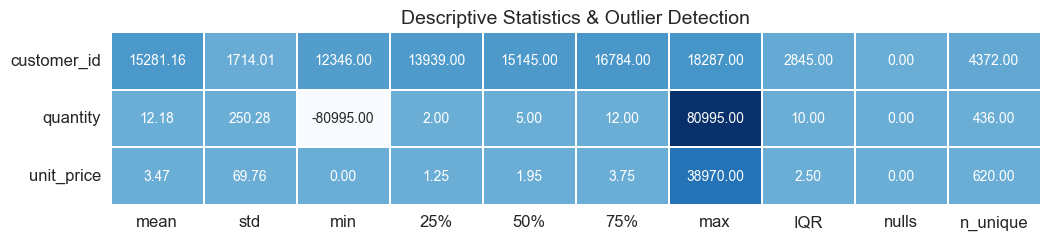

In [12]:
def find_out(dataframe):

# finding the inter quartile range (IQR) - focus on the middle 50% of values

  desc = dataframe.describe().T

  # Calculate IQR
  desc['IQR'] = desc['75%'] - desc['25%']

  # Add null count and unique count
  desc['nulls'] = dataframe.isnull().sum()
  desc['n_unique'] = dataframe.nunique()

  # are there outliers - used a threshold of +/- (1.5 * IQR)

  desc['max_outlier'] = desc['max'] > (desc['75%'] + 1.5 * desc['IQR'])
  desc['min_outlier'] = desc['min'] < (desc['25%'] - 1.5 * desc['IQR'])


  #Select columns to display as heatmap - derived from the dataframe.decribe() function
  out_df = desc[['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'IQR', 'nulls', 'n_unique']]

  # Plot heatmap
  f, ax = plt.subplots(figsize=(12, out_df.shape[0] * 0.75))
  sns.heatmap(out_df,
              annot=True,
              cmap="Blues",
              fmt=".2f",
              ax=ax,
              linecolor="white",
              linewidths=1.1,
              cbar=False,
              annot_kws={"size": 10})

  plt.xticks(size=12)
  plt.yticks(size=12, rotation=0)
  plt.title("Descriptive Statistics & Outlier Detection", size=14)
  plt.show()

# only include the numerical datatypes

find_out(df.select_dtypes(include = [float, int]))

## Inferences:

Quantity:

1. Average Quantity per transaction is around 12 units.
2. std is relatively large at around 250 units per transaction.
3.**Quantity min is showing negative values meaning that a negative quanity of products were purchased - this could indicate a return from the customer or potential canceled orders**
4. IQR is 10 units
5. **max value is unrealistically higher than the IQR - this is abnormally large**

Unit Price:

1. Average unit price was 3.46
2. std at around 70 GBP
3. **Min is 0** this indicates unrealistic outliers- this could indicate promotional items such as giveaways.
4. **Should we eliminate the large max value ?** this could be helpful to our analysis ?
5. There are 620 unique unit prices - wholesale dataset  

Customer ID:
1. There are 4372 unique customers

Considerations:
1. Quantity - Cap Values
2. Unit - Cap Values
3. **Investigate the Order numbers marked with C to describe canceled orders**

In [13]:
def remove_canceled_orders(df):
    """
    Removes canceled transactions from the dataset.
    Canceled transactions are typically indicated by invoice_no starting with 'C'.

    Parameters:
        df (pd.DataFrame): Input transaction-level data.

    Returns:
        pd.DataFrame: Cleaned data without canceled transactions.
    """
    df = df.copy()
    df['invoice_no'] = df['invoice_no'].astype(str)
    df = df[~df['invoice_no'].str.startswith('C')]
    return df
# Clean your original dataset
df = remove_canceled_orders(df)


In [34]:
# find the total number of distinct invoice numbers vs the total invoice numbers

# total rows (all „invoice_no“ values)
total_invoices = len(df['invoice_no'])

# how many distinct invoices
unique_invoices = df['invoice_no'].nunique()

print(f"Total rows: {total_invoices:,}")      # e.g. 406,529
print(f"Distinct invoices: {unique_invoices:,}")


Total rows: 392,732
Distinct invoices: 18,536


### 📦 Build Customer-Level Summary Table

This function transforms raw invoice-level transaction data into **customer-level aggregates** for use in RFM scoring and CLV modeling.

**What it does:**
- Converts the `invoice_date` column to datetime format for accurate date math.
- Calculates `line_total` for each row as `unit_price × quantity`.
- Identifies the most recent purchase date in the dataset to compute **recency**.
- Groups by `customer_id` to compute the following features:
  - 🧾 `orders`: number of unique invoices (proxy for purchase frequency).
  - 🗓️ `first_date`, `last_date`: customer’s first and most recent purchase dates.
  - 💰 `monetary`: total spend across all orders.
  - 📊 `avg_order_value`: average basket size per transaction.
  - 🌍 `country`: preserved as-is (first observed country per customer).
- Derives:
  - 📅 `recency`: days since the last purchase.
  - 🔁 `frequency`: number of distinct orders.
  - ⏳ `obs_months`: time span (in months) between first and last purchase, clipped at minimum of 1 to avoid division issues.

**Why it's important:**
This table condenses raw transactional logs into a **compact customer view** that feeds directly into:
- 📐 RFM scoring logic
- 📈 CLV predictive models
- 📦 Customer segmentation

**Returns:** A DataFrame with one row per customer and engineered fields that describe their purchase behavior.


In [15]:
def build_customer_summary(df):
    """
    Aggregates invoice-level data to generate customer-level metrics for RFM and CLV analysis.

    Parameters:
        df (pd.DataFrame): Must include columns ['invoice_no', 'invoice_date', 'customer_id',
                                                 'unit_price', 'quantity', 'country']

    Returns:
        pd.DataFrame: Aggregated customer-level DataFrame with:
                      ['orders', 'first_date', 'last_date', 'monetary', 'avg_order_value',
                       'country', 'recency', 'frequency', 'obs_months']
    """
    # Ensure datetime format for date column
    df['order_date'] = pd.to_datetime(df['invoice_date'])

    # Precompute line total = unit_price × quantity
    df['line_total'] = df['unit_price'] * df['quantity']

    # Track latest date for recency calc
    max_order_date = df['order_date'].max()

    # Group by customer and aggregate
    cust = df.groupby('customer_id').agg(
        orders=('invoice_no', 'nunique'),
        first_date=('order_date', 'min'),
        last_date=('order_date', 'max'),
        monetary=('line_total', 'sum'),
        avg_order_value=('line_total', 'mean'),
        country=('country', 'first')
    )

    # Add recency, frequency, and observation months
    cust = cust.assign(
        recency=(max_order_date - cust['last_date']).dt.days,
        frequency=cust['orders'],
        obs_months=((cust['last_date'] - cust['first_date']).dt.days / 30).clip(lower=1)
    )

    return cust.reset_index()

In [16]:
# 1. Build customer table
cust = build_customer_summary(df)

## 3. RFM Feature Engineering

### 🧮 Compute RFM Scores and Estimate 12-Month CLV

This function takes a **customer-level summary DataFrame** and enhances it with:
1. **RFM Scores** (Recency, Frequency, Monetary)
2. A **12-month CLV estimate** using a simplified revenue projection formula.

---

**What it does:**

#### 🔢 RFM Scoring
- **Recency Score**: Lower recency (i.e., more recent activity) is better. Customers are ranked into 5 quantiles (`pd.qcut` on `-recency`).
- **Frequency Score**: Higher number of orders = higher score.
- **Monetary Score**: Total amount spent across all purchases.

Each score ranges from **1 (lowest)** to **5 (highest)**.

- ✅ Adds a new column `rfm_total` = sum of all three scores.
- 🎯 Used to rank customers and segment them (e.g., into “Champions”, “At-Risk”, etc.)

#### 💸 CLV Estimate
Calculates **12-month Customer Lifetime Value (CLV)** using a basic revenue projection formula
This gives an expected value from each customer over the next year based on their past behavior.

---

**Why it's important:**
- 🎯 **RFM scores** help with segmentation, targeting, and prioritizing customer retention efforts.
- 📈 **CLV** predicts future revenue potential, useful for ROI-driven marketing and strategic planning.

**Returns:** The original customer-level DataFrame with five new columns:
- `recency_score`
- `frequency_score`
- `monetary_score`
- `rfm_total`
- `clv_12mo` (rounded to 2 decimals)


In [17]:
def compute_rfm_clv(df):
    """
    Adds RFM scores and 12-month CLV estimate to the input customer-level DataFrame.

    Parameters:
        df (pd.DataFrame): Must include columns ['recency', 'frequency', 'monetary', 'avg_order_value', 'obs_months']

    Returns:
        pd.DataFrame: Original DataFrame with added columns:
                      ['recency_score', 'frequency_score', 'monetary_score', 'rfm_total', 'clv_12mo']
    """
    df = df.copy()

    # Protect against division by zero
    df['obs_months'] = df['obs_months'].clip(lower=1)

    # RFM Scores (1 = lowest, 5 = highest)
    df['recency_score'] = pd.qcut(-df['recency'], q=5, labels=False, duplicates='drop') + 1
    df['frequency_score'] = pd.qcut(df['frequency'], q=5, labels=False, duplicates='drop') + 1
    df['monetary_score'] = pd.qcut(df['monetary'], q=5, labels=False, duplicates='drop') + 1

    # Total RFM score
    df['rfm_total'] = df['recency_score'] + df['frequency_score'] + df['monetary_score']

    # Estimate 12-month CLV
    df['clv_12mo'] = round(
        df['avg_order_value'] * (df['frequency'] / df['obs_months']) * 12, 2
    )

    return df

## 4. CLV Modeling

In [18]:
cust = compute_rfm_clv(cust)
cust

In [20]:
def cap_outliers(df, columns, upper_quantile=0.98):
    """
    Caps values in specified columns at the given upper quantile threshold.

    Parameters:
        df (pd.DataFrame): DataFrame with raw data
        columns (list): List of column names to cap
        upper_quantile (float): Quantile threshold to cap (default is 0.98)

    Returns:
        pd.DataFrame: Modified DataFrame with capped values
    """
    df = df.copy()  # prevent mutation
    for col in columns:
        upper_limit = df[col].quantile(upper_quantile)
        df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])
    return df


In [21]:
rfm_cols = ['recency', 'frequency', 'monetary']
cust = cap_outliers(cust, rfm_cols, upper_quantile=0.95)


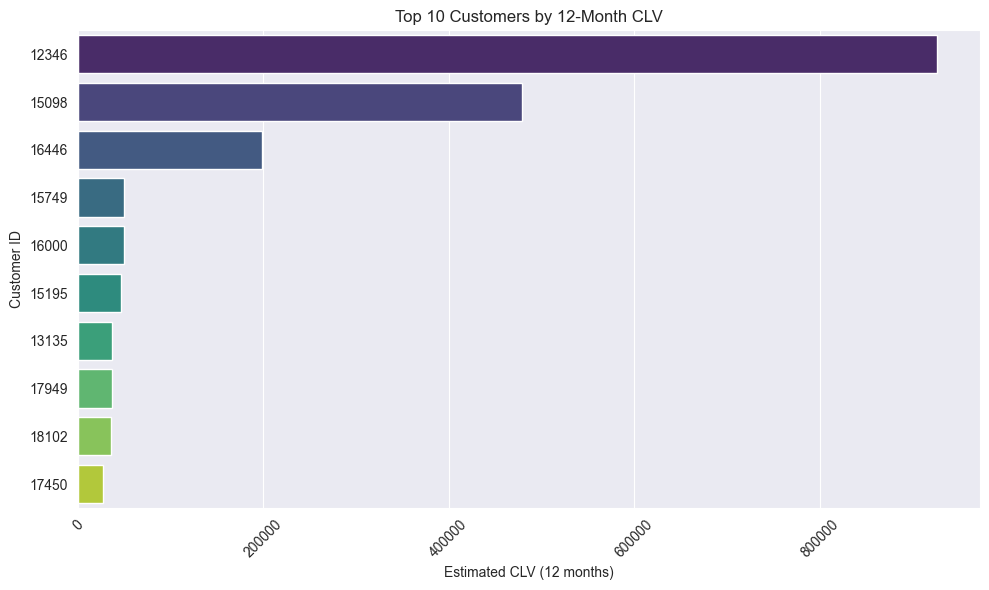

In [22]:
# Plot 1: Top 10 Customers by CLV
# Get top 10 customers by CLV
# Fix: Reset index to bring customer_id into columns
top_clv = cust.nlargest(10, 'clv_12mo').copy().reset_index()

# Then convert customer_id to string for labeling
top_clv['customer_id'] = top_clv['customer_id'].astype(int).astype(str)


# Plot
plt.figure(figsize=(10, 6))
# Add 'hue' and suppress legend to fix Seaborn warning
sns.barplot(
    x='clv_12mo',
    y='customer_id',
    hue='customer_id',           # Assign y-axis value as hue for coloring
    data=top_clv,
    palette='viridis',
    legend=False                 # Hide legend since it's redundant
)

# Styling
plt.title('Top 10 Customers by 12-Month CLV')
plt.xlabel('Estimated CLV (12 months)')
plt.ylabel('Customer ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 🔍 What the Chart Shows

1. The **X-axis** represents estimated **Customer Lifetime Value (CLV)** over the next 12 months — i.e., how much revenue each customer is expected to generate.

2. The **Y-axis** shows the **Customer IDs** of your top 10 highest-value customers.

3. The **height of each bar** corresponds to the customer’s projected revenue, allowing for easy comparison of value contribution across the top cohort.



### 💡 Insights from CLV Analysis

#### 1. Highly Skewed Value Contribution
- A few customers (those around **$35K–$49K**) are significantly more valuable than others.
- This suggests a classic **80/20 Pareto pattern** — a small group of customers drives a large share of revenue.

---

#### 2. Retention & Upsell Opportunities
- The **top 3 customers** have projected values near or above **$36K**.
  - These are your **VIPs** and should be prioritized for:
    - Loyalty perks
    - Upselling opportunities
    - Exclusive offers
- **Customer ID ≠ Consistency**:
  - The spread of customer IDs shows that **high CLV isn't limited to early adopters** — any customer can grow into a top spender.

---

#### 3. Strategic Marketing Insight
- Targeted retention efforts for the **top 10 customers** can lead to **significant revenue uplift**.
- You can build a **lookalike segment** by analyzing behavior patterns of these high-value users:
  - Purchase frequency
  - Product preferences
  - Engagement channels


### Plot 2: RFM Heatmap (Frequency vs. Recency by Monetary)

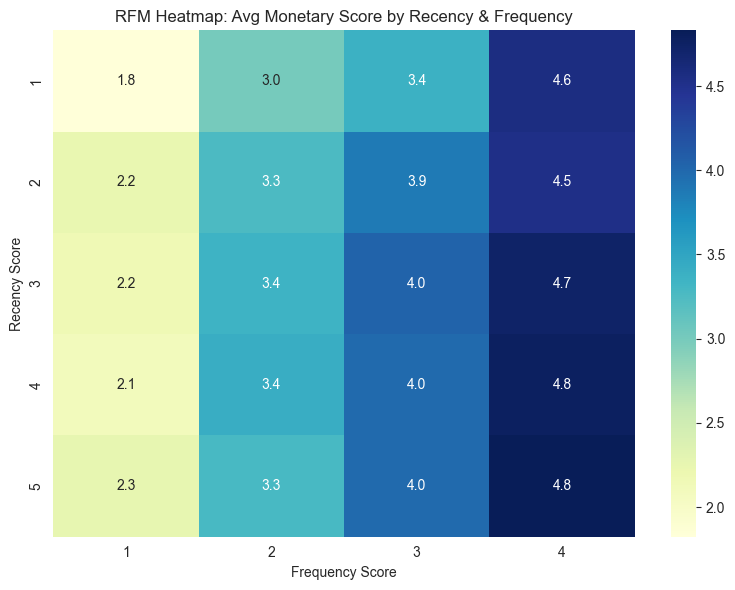

In [23]:
rfm_pivot = cust.pivot_table(index='recency_score', columns='frequency_score', values='monetary_score', aggfunc='mean')

plt.figure(figsize=(8, 6))
sns.heatmap(rfm_pivot, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('RFM Heatmap: Avg Monetary Score by Recency & Frequency')
plt.xlabel('Frequency Score')
plt.ylabel('Recency Score')
plt.tight_layout()
plt.show()

### 🔍 What the Heatmap Shows

1. The **X-axis** represents the **Frequency Score** (1 to 5), where higher scores mean the customer purchases more often.

2. The **Y-axis** represents the **Recency Score** (1 to 5), where higher scores mean the customer made a **more recent** purchase.

3. Each **cell value** shows the **average Monetary Score** (1 to 5) for customers in that Recency × Frequency combination — i.e., how much they tend to spend.

---

### 💡 Insights

- **High monetary scores cluster in the top-right corner** (Recency = 5, Frequency = 4 or 5):
  These are your **most engaged and high-spending customers** — recent, frequent, and generous.

- **Low scores in the bottom-left**:
  Customers with **low frequency and old purchases** spend the least — likely churned or low-value.

- **Target the 4×4 and 5×4 zones**:
  Customers here are **prime candidates** for upselling, loyalty programs, and retention strategies.

- **Middle tiers (Recency 3–4, Frequency 2–3)** show stable but moderate spending — you can explore nudging these upward through targeted campaigns.


### 📊 Boxplots of RFM Features

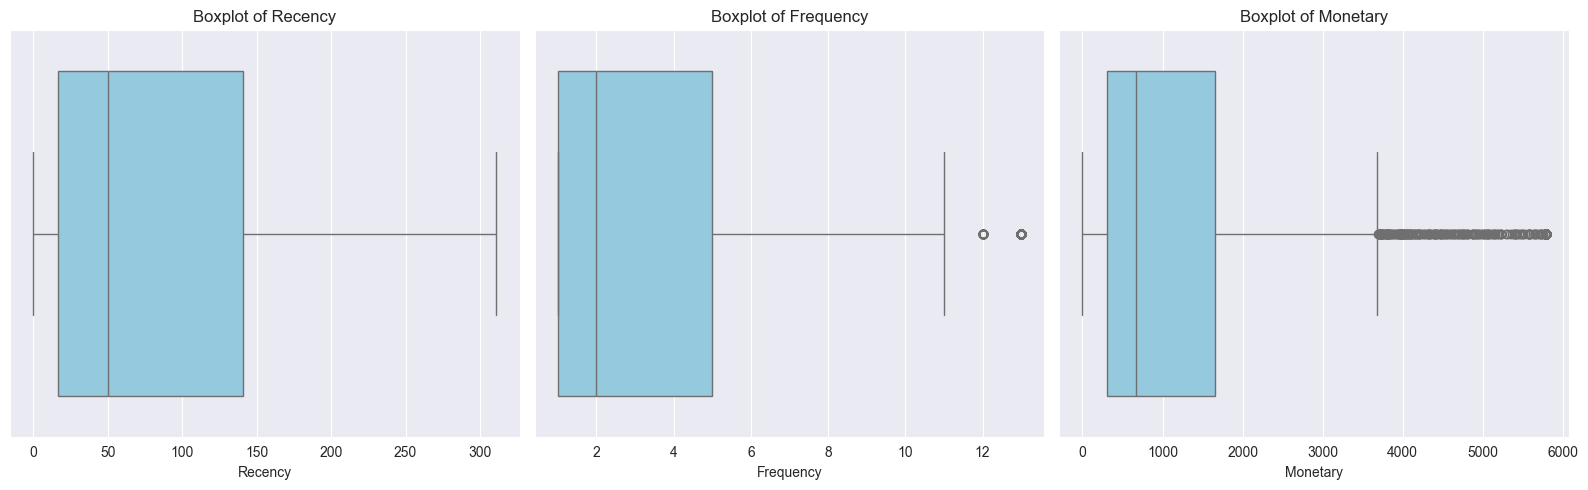

In [24]:
# Set up a 1x3 grid of box plots for RFM features
plt.figure(figsize=(16, 5))

for i, col in enumerate(['recency', 'frequency', 'monetary'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=cust[col], color='skyblue')
    plt.title(f'Boxplot of {col.capitalize()}')
    plt.xlabel(col.capitalize())

plt.tight_layout()
plt.show()


This chart provides a quick visual summary of the **distribution and spread** of the three core RFM metrics across customers:

- **Recency** (days since last purchase)
- **Frequency** (number of orders)
- **Monetary** (total spend)

**What to look for:**
- The **box** shows the interquartile range (middle 50% of customers).
- **Lines** extending from the box show the overall spread (min/max, excluding outliers).
- **Dots** are potential outliers—often your top spenders or most frequent buyers.

These plots help identify skewed distributions and outliers that may influence clustering or CLV calculations.


### 🎯 Segment Customers by Value & Behavior

This section uses a rule-based function to assign customers into meaningful business segments based on their RFM score and predicted 12-month CLV.

Defined segments:
- **Gold Loyalists**: High RFM + High CLV
- **Silver Steady**: Medium RFM + High CLV
- **Bronze Bargain-Hunters**: Low RFM
- **At-Risk**: Low RFM and CLV

This allows us to group customers for targeted retention and acquisition strategies.


In [25]:
def assign_customer_segment(df, clv_threshold=250):
    """
    Assigns each customer to a segment based on RFM score and CLV value.

    Parameters:
        df (pd.DataFrame): Must contain columns ['rfm_total', 'clv_12mo']
        clv_threshold (float): Threshold for high CLV customers (default: 250)

    Returns:
        pd.DataFrame: Original DataFrame with an added 'segment' column
    """
    def segment_row(row):
        if row['rfm_total'] >= 12 and row['clv_12mo'] >= clv_threshold:
            return 'Gold Loyalists'
        elif 8 <= row['rfm_total'] < 12 and row['clv_12mo'] >= clv_threshold:
            return 'Silver Steady'
        elif 4 <= row['rfm_total'] < 8:
            return 'Bronze Bargain-Hunters'
        else:
            return 'At-Risk'

    df['segment'] = df.apply(segment_row, axis=1)
    return df


In [26]:
# Assign segments
cust = assign_customer_segment(cust)

# Count segments by country
segment_summary = cust.groupby(['country', 'segment']).size().reset_index(name='customer_count')

# Sort for easier analysis
segment_summary = segment_summary.sort_values(['country', 'customer_count'], ascending=[True, False])
segment_summary = segment_summary.reset_index(drop=True)

segment_summary = segment_summary.sort_values(
    by=['country', 'customer_count'],
    ascending=[True, False]
)

gold_loyalists = segment_summary[segment_summary['segment'] == 'Gold Loyalists']
gold_loyalists = gold_loyalists.sort_values('customer_count', ascending=False)





In [41]:
segment_summary

,country,segment,customer_count
0,Australia,Bronze Bargain-Hunters,5
1,Australia,At-Risk,2
2,Australia,Gold Loyalists,2
3,Austria,Bronze Bargain-Hunters,4
4,Austria,At-Risk,3
...,...,...,...
88,United Kingdom,Bronze Bargain-Hunters,1667
89,United Kingdom,At-Risk,1601
90,United Kingdom,Gold Loyalists,354
91,United Kingdom,Silver Steady,299


In [42]:
gold_loyalists

,country,segment,customer_count
90,United Kingdom,Gold Loyalists,354
39,Germany,Gold Loyalists,18
35,France,Gold Loyalists,13
61,Norway,Gold Loyalists,3
30,Finland,Gold Loyalists,3
48,Italy,Gold Loyalists,3
79,Sweden,Gold Loyalists,2
76,Spain,Gold Loyalists,2
68,Portugal,Gold Loyalists,2
2,Australia,Gold Loyalists,2


### 📌 Interpretation: Segment Distribution by Country

The `segment_summary` table reveals how different customer segments are distributed across countries.

- The **United Kingdom** has by far the highest concentration of **Gold Loyalists** (354 customers), making it the most valuable market for retention and loyalty efforts.
- Other notable countries with high-value customers include **Germany**, **France**, and **Finland**, albeit in much smaller volumes.
- Segments like **At-Risk** and **Bronze Bargain-Hunters** are also present in multiple regions, which may indicate churn risk or low spending potential.

**Business Insight:**
You can use this segmentation to drive **geo-targeted marketing strategies**, focusing loyalty programs and personalized engagement on countries with the highest density of high-CLV customers.


## 5. Segmentation & Visualization

### 📊 Unsupervised Clustering of Customers (RFM Segmentation)

This project applied **KMeans clustering** to **RFM data** (Recency, Frequency, Monetary) to uncover customer segments. The workflow included feature engineering, transformation, clustering, dimensionality reduction, and segment interpretation.

---

**✅ RFM Features Defined:**

- **Recency**: Days since the customer's last purchase
- **Frequency**: Total number of transactions
- **Monetary**: Total revenue generated per customer

---

**🧪 Data Transformation:**

- Features were **standardized** and **log-transformed** to ensure comparability and reduce skewness in distribution.

---

**🔍 Clustering Approach:**

- **KMeans** clustering was used to group customers into distinct segments based on purchasing behavior.
- The algorithm works by minimizing within-cluster variance to find natural groupings.

---

**📉 Dimensionality Reduction:**

- **PCA (Principal Component Analysis)** was applied to project the 3D RFM data into 2D space.
- This allowed for effective visualization of customer clusters.

---

**🎯 Segment Interpretation:**

- Clusters were labeled into marketing-relevant personas, such as:
  - *At-Risk Value*
  - *High-Spending Sleepers*
  - *Loyal Frequent Buyers*

This segmentation can inform targeted marketing strategies and customer retention efforts.


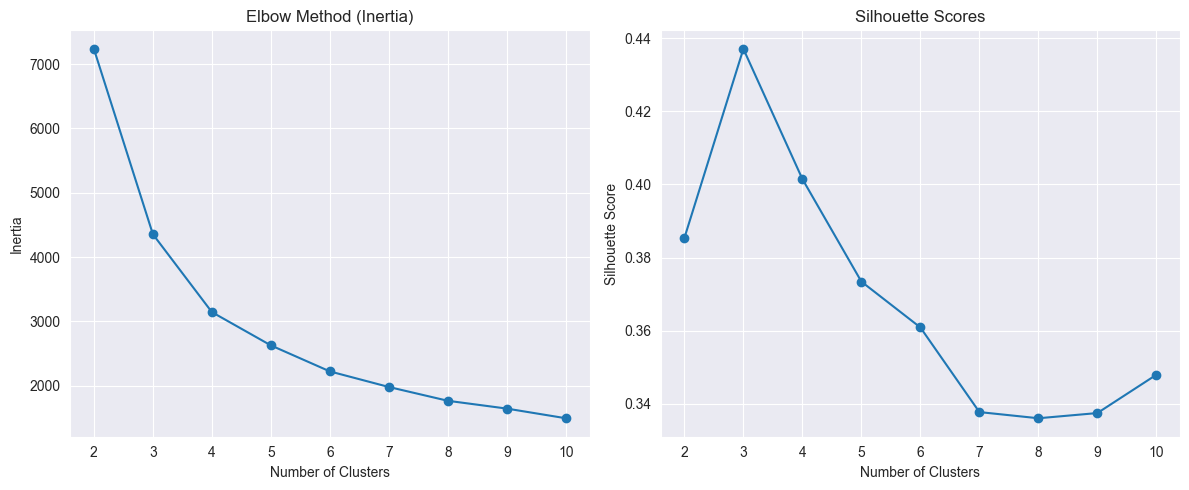

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use only RFM features
rfm_features = cust[['recency', 'frequency', 'monetary']].copy()

# Apply log(1 + x) transformation to monetary only (already cleaned of negative values)
cust['monetary'] = np.log1p(cust['monetary'])

# Re-scale the RFM features after log transformation
from sklearn.preprocessing import StandardScaler

rfm_cols = ['recency', 'frequency', 'monetary']
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(cust[rfm_cols])

# Use the Elbow Method to determine the optimal number of clusters
inertia = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(rfm_scaled)
    inertia.append(model.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, model.labels_))

# Plot the Elbow Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


In [30]:
# Apply KMeans with the optimal number of clusters (k=4)
kmeans = KMeans(n_clusters=3, random_state=42)
cust['cluster'] = kmeans.fit_predict(rfm_scaled)

# Summarize the characteristics of each cluster
cluster_summary = cust.groupby('cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'customer_id': 'count'
}).rename(columns={'customer_id': 'num_customers'}).reset_index()

cluster_summary

,cluster,recency,frequency,monetary,num_customers
0,0,49.410357,2.371628,6.331832,2298
1,1,24.063701,8.789687,8.037663,989
2,2,239.651141,1.434411,5.620040,1052


In [31]:
# Run PCA (assuming rfm_scaled is your scaled RFM features)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

# Add PCA columns to your main cust DataFrame
cust['pca1'] = pca_components[:, 0]
cust['pca2'] = pca_components[:, 1]


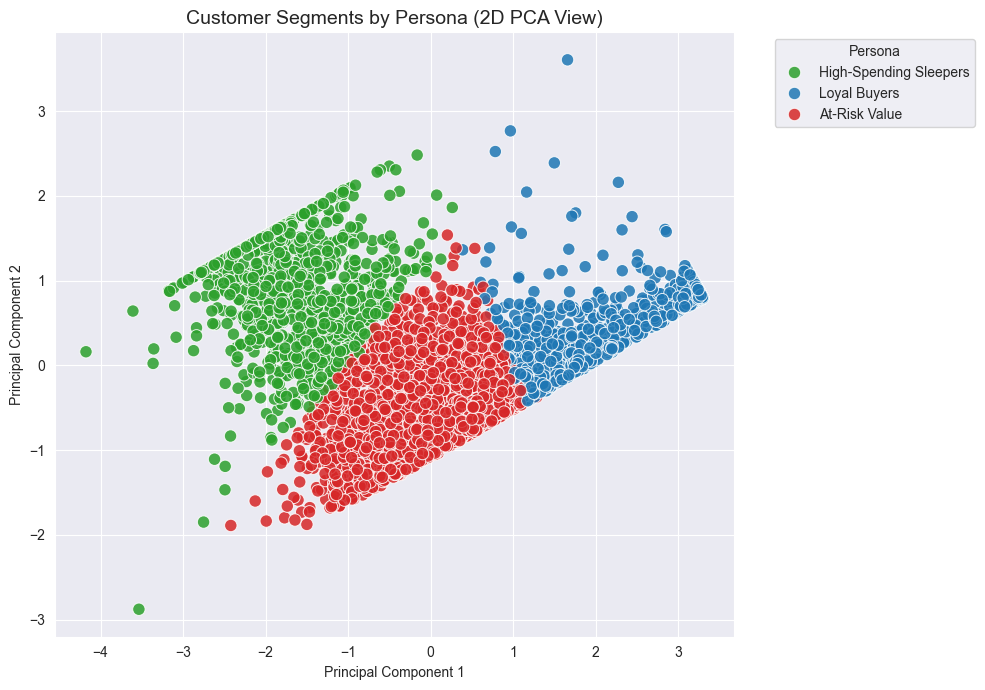

In [38]:
# Create a function to assign persona names based on cluster IDs
def map_personas(df):
    persona_map = {
        0: 'At-Risk Value',
        1: 'Loyal Buyers',
        2: 'High-Spending Sleepers',
        3: 'New/Casual Buyers'
    }
    df['persona'] = df['cluster'].map(persona_map)
    return df

# Apply the persona mapping
cust = map_personas(cust)

palette = {
    'Loyal Buyers': '#1f77b4',         # bold blue
    'At-Risk Value': '#d62728',        # strong red
    'High-Spending Sleepers': '#2ca02c',  # green
    'New/Casual Buyers': '#ff7f0e'     # orange
}


# Plot the PCA visualization with labeled personas
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='pca1', y='pca2',
    hue='persona',
    palette= palette,
    data=cust,
    alpha=0.85,
    s=80
)

# Add title and formatting
plt.title('Customer Segments by Persona (2D PCA View)', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Persona', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### 🧠 Customer Segmentation Analysis (via PCA)

The scatterplot above presents a 2D Principal Component Analysis (PCA) projection of customers based on their **Recency**, **Frequency**, and **Monetary (RFM)** scores. Each point represents a customer, and colors correspond to persona segments derived from **KMeans clustering**.

#### 🔍 Key Insights:

1. **Clear Separation Between Personas**
   The PCA projection reveals **distinct clusters** in customer behavior:
   - **Loyal Buyers** form a compact group, indicating consistent purchasing activity with high frequency and low recency.
   - **High-Spending Sleepers** are spatially distant, suggesting they’ve made large purchases historically but may have lapsed.
   - **At-Risk Value** customers cluster separately, representing infrequent or low-spend buyers.

2. **Dimensionality Reduction Preserved Segment Structure**
   Despite compressing 3 features into 2 dimensions, the plot retains strong visual separation. This validates both the clustering process and the explanatory power of RFM metrics.

3. **Actionable Groupings**
   The persona labels make it easy to tailor marketing strategies:
   - **Loyal Buyers** could be nurtured with loyalty rewards.
   - **High-Spending Sleepers** may be re-engaged via personalized win-back campaigns.
   - **At-Risk** customers may need deeper incentives or churn-prevention efforts.

#### 📊 Technical Notes:
- **Log transformation** and **outlier capping** were applied before PCA to reduce skewness and enhance cluster integrity.
- **3 clusters** were chosen based on a balance of the **elbow method** and **silhouette scores**.


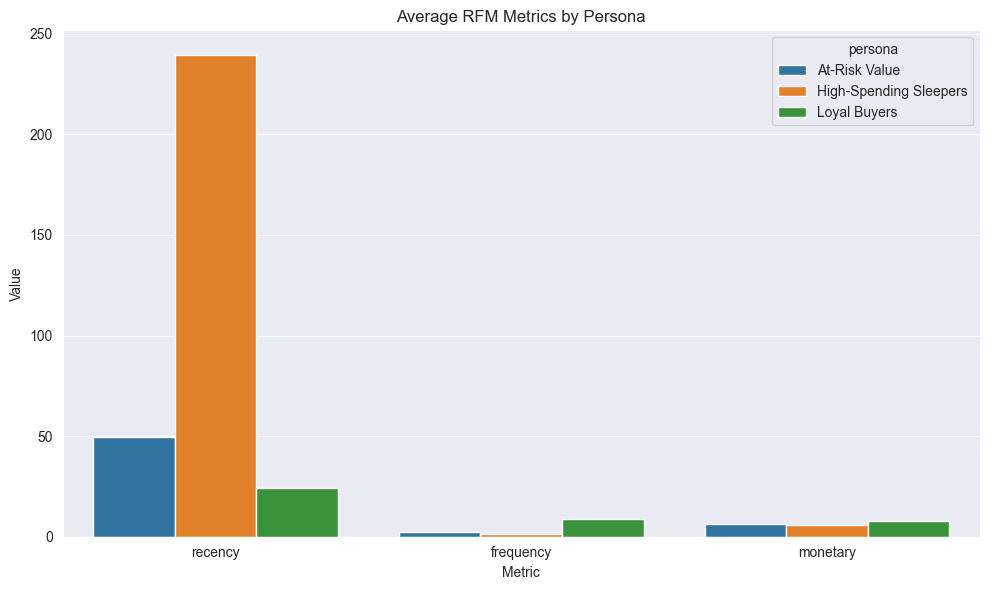

In [39]:
cluster_summary = (
    cust.groupby('persona')
    .agg({
        'recency': 'mean',
        'frequency': 'mean',
        'monetary': 'mean',
        'customer_id': 'count'  # size of segment
    })
    .rename(columns={'customer_id': 'num_customers'})
    .reset_index()
)

# visualize as barplots for each metric
melted = cluster_summary.melt(id_vars='persona',
                              value_vars=['recency', 'frequency', 'monetary'],
                              var_name='Metric', value_name='Value')

plt.figure(figsize=(10,6))
sns.barplot(data=melted, x='Metric', y='Value', hue='persona')
plt.title('Average RFM Metrics by Persona')
plt.tight_layout()
plt.show()


### 📊 Interpreting RFM Averages by Customer Segment

This chart visualizes the **average RFM metrics**—Recency, Frequency, and Monetary value—for each of the customer segments discovered through clustering.

Each bar represents the **average value** of one metric for one customer persona:

#### 🔍 Metrics Explained:
- **Recency**: Days since the customer's last purchase (⚠️ lower is better)
- **Frequency**: Total number of purchases (✅ higher is better)
- **Monetary**: Total revenue generated by the customer (✅ higher is better)

---

### 🧠 Segment Insights:

#### ✅ **Loyal Buyers**
- **Low Recency** → These customers purchased recently.
- **High Frequency** → They make repeat purchases often.
- **High Monetary Value** → They spend a lot annually.
- 🔑 **Insight**: This is the company’s most engaged and profitable segment. Marketing teams should prioritize loyalty programs and upsell strategies for them.

#### ⚠️ **High-Spending Sleepers**
- **Very High Recency** → These customers haven’t purchased in a long time.
- **Low Frequency** → They don’t buy often.
- **High Monetary Value** → However, when they do buy, they spend a lot.
- 🔑 **Insight**: These customers are valuable but dormant. They are ideal targets for win-back or re-engagement campaigns.

#### ❌ **At-Risk Value**
- **Medium-to-High Recency** → It’s been a while since they purchased.
- **Low Frequency** → They have not engaged much.
- **Low Monetary Value** → They contribute the least revenue.
- 🔑 **Insight**: These customers are low-value and possibly close to churn. Marketing teams could deprioritize them or test discount-based revival campaigns.

---

### 🎯 Why It Matters:
This visualization helps marketing teams:
- Personalize campaigns for each persona.
- Allocate resources toward high-impact customer groups.
- Design retention and reactivation strategies based on behavioral traits.

It bridges data science with actionable customer segmentation—turning clustering outputs into strategic decisions.
